In [3]:
# Clen data before making a baseline model

import pandas as pd
import numpy as np

df = pd.read_csv('Stocks_MergedSentiments_Combined.csv')

# Convert daily_return to numeric
df['daily_return'] = pd.to_numeric(df['daily_return'], errors='coerce')

# Drop rows with missing daily_return or sentiment
df = df.dropna(subset=['daily_return', 'news_score', 'twitter_score'])

# Remove rows where both twitter and news sentiment are neutral
df = df[~((df['twitter_score'] == 0) & (df['news_score'] == 0))]

# Confirm shape
print("Shape after filtering:", df.shape)

df.head(10)

Shape after filtering: (9583, 15)


,date,ticker,price,volume,daily_return,dividend,low_bid,high_ask,sp500_return,news_score,twitter_score,final_sentiment_score,sentiment_1d,sentiment_3d_avg,sentiment_7d_avg
3,03/10/2022,ORCL,76.65,13812596.0,0.007227,NaN,75.030,76.8500,-0.004292,-1.000000,0.000000,-0.650000,0.320458,-0.109847,0.064069
7,06/13/2022,ORCL,64.05,16547246.0,-0.046023,NaN,63.760,66.1000,-0.038768,1.000000,0.000000,0.650000,0.325000,0.325000,0.169556
9,06/16/2022,ORCL,68.71,10685987.0,-0.014204,NaN,67.580,68.9600,-0.032512,0.000000,0.412748,0.144462,0.000000,0.178154,0.215637
11,07/27/2022,ORCL,75.87,6677226.0,0.024855,NaN,74.320,76.1200,0.026156,0.000000,0.520375,0.182131,0.000000,0.166685,0.224635
13,09/12/2022,ORCL,77.08,15628850.0,0.015413,NaN,76.270,77.3771,0.010584,-0.497464,0.000000,-0.323352,0.000000,-0.107784,0.019205
16,12/12/2022,ORCL,81.28,15807550.0,0.017781,NaN,79.935,81.4100,0.014279,0.500000,0.000000,0.325000,0.162499,0.162500,0.080679
18,12/19/2022,ORCL,80.50,7738813.0,0.011561,NaN,79.680,81.1000,-0.009007,0.000000,0.471924,0.165173,0.000000,0.072819,-0.014236
24,03/10/2023,ORCL,84.07,16029345.0,-0.032232,NaN,82.880,85.2500,-0.014478,-0.999994,0.000000,-0.649996,-0.650000,-0.326512,-0.028787
25,03/24/2023,ORCL,88.01,5852248.0,0.002620,NaN,87.510,88.4800,0.005640,0.999989,0.000000,0.649993,0.185931,0.278641,-0.066282
27,05/17/2023,ORCL,99.77,9436009.0,0.015471,NaN,98.430,100.4000,0.011891,0.000000,0.664784,0.232674,0.000000,0.077558,0.218953


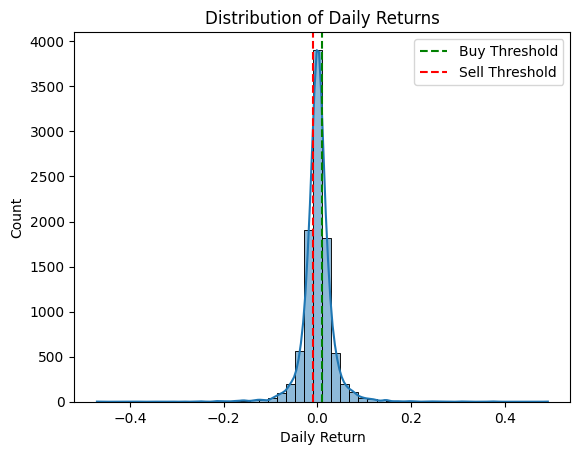

In [4]:
# get a base threshold based on our data to make sure the action applied for buy, sell and hold is accurate and thoughtful

import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of daily return
sns.histplot(df['daily_return'], bins=50, kde=True)
plt.axvline(0.01, color='green', linestyle='--', label='Buy Threshold')
plt.axvline(-0.01, color='red', linestyle='--', label='Sell Threshold')
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.legend()
plt.show()

In [7]:
# applyign action labels

# Set thresholds based on distribution
buy_threshold = 0.015
sell_threshold = -0.015

# Define action column
def label_action(ret):
    if ret >= buy_threshold:
        return 'Buy'
    elif ret <= sell_threshold:
        return 'Sell'
    else:
        return 'Hold'

df['action'] = df['daily_return'].apply(label_action)

In [9]:
# Feature selection
features = [
    'price', 'volume', 'low_bid', 'high_ask', 'sp500_return',
    'news_score', 'twitter_score', 'final_sentiment_score',
    'sentiment_1d', 'sentiment_3d_avg', 'sentiment_7d_avg'
]

# Drop missing values (if any)
model_df = df.dropna(subset=features + ['action'])

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Encode the target variable
le = LabelEncoder()
model_df['action_encoded'] = le.fit_transform(model_df['action'])

# Split data
X = model_df[features]
y = model_df['action_encoded']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


<ipython-input-10-529d1f23c8dc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['action_encoded'] = le.fit_transform(model_df['action'])


RandomForestClassifier(random_state=42)

In [11]:
# predictions
y_pred = model.predict(X_test)

In [13]:
# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         Buy       0.58      0.36      0.44       439
        Hold       0.63      0.83      0.72      1064
        Sell       0.53      0.31      0.39       396

    accuracy                           0.61      1899
   macro avg       0.58      0.50      0.52      1899
weighted avg       0.60      0.61      0.59      1899

Confusion Matrix:
[[156 262  21]
 [ 93 882  89]
 [ 21 252 123]]


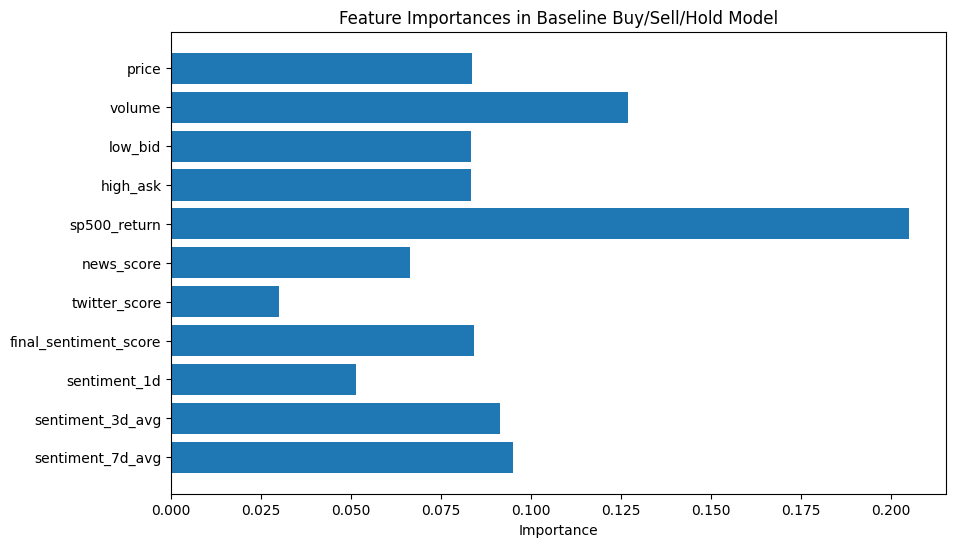

In [14]:
# STEP 9: Feature Importance
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Feature Importances in Baseline Buy/Sell/Hold Model')
plt.gca().invert_yaxis()
plt.show()

In [15]:
# Fine tuned model

# Select features (based on your importance plot)
features = [
    'price', 'volume', 'low_bid', 'high_ask', 'sp500_return',
    'news_score', 'twitter_score', 'final_sentiment_score',
    'sentiment_3d_avg', 'sentiment_7d_avg'  # skipped 1d due to low signal
]

model_df = model_df.dropna(subset=features + ['action'])

# Train-test split
X = model_df[features]
y = model_df['action_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fine-tuned Random Forest Classifier
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=3,
    class_weight='balanced',
    random_state=42
)

In [16]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [17]:
# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         Buy       0.51      0.50      0.51       439
        Hold       0.67      0.64      0.66      1064
        Sell       0.45      0.51      0.47       396

    accuracy                           0.58      1899
   macro avg       0.54      0.55      0.55      1899
weighted avg       0.59      0.58      0.58      1899


Confusion Matrix:
[[220 168  51]
 [182 683 199]
 [ 30 165 201]]


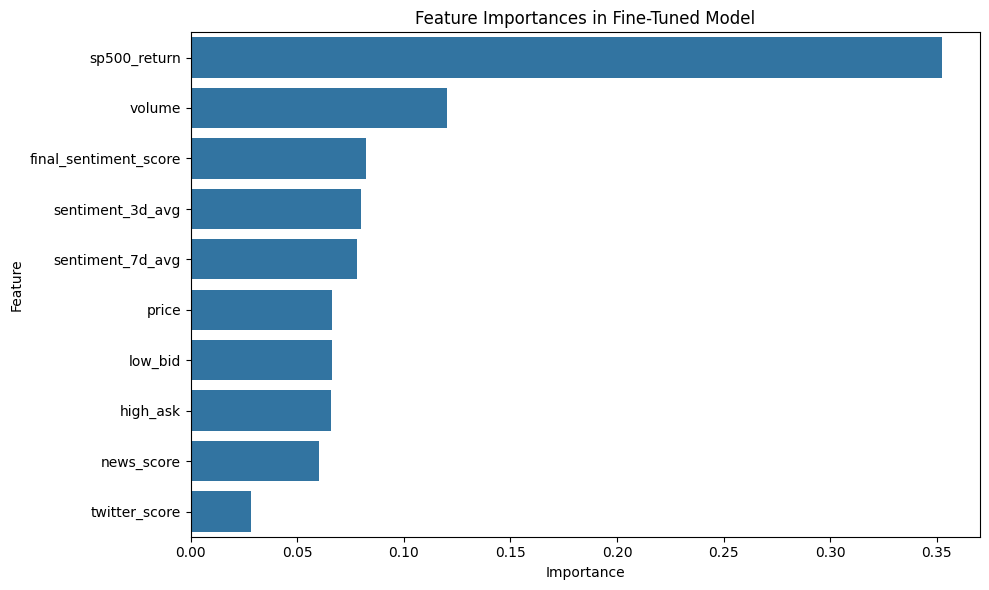

In [18]:
# Visualize Feature Importance
importances = clf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importances in Fine-Tuned Model')
plt.tight_layout()
plt.show()

In [25]:
# XGboost model

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Feature selection
features = [
    'price', 'volume', 'low_bid', 'high_ask', 'sp500_return',
    'news_score', 'twitter_score', 'final_sentiment_score',
    'sentiment_1d', 'sentiment_3d_avg', 'sentiment_7d_avg']

# Label encoding already done: model_df['action_encoded']
le = LabelEncoder()
df['action_encoded'] = le.fit_transform(df['action'])

X = df[features]
y = df['action_encoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Tuned XGBoost
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.2, 0.4]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

xgb_best = xgb_grid.best_estimator_
xgb_preds = xgb_best.predict(X_test)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:13:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [26]:
print(" XGBoost Results")
print(classification_report(y_test, xgb_preds, target_names=le.classes_))
print(confusion_matrix(y_test, xgb_preds))


🔥 XGBoost Results
              precision    recall  f1-score   support

         Buy       0.60      0.36      0.45       444
        Hold       0.64      0.86      0.73      1074
        Sell       0.61      0.34      0.43       399

    accuracy                           0.63      1917
   macro avg       0.62      0.52      0.54      1917
weighted avg       0.63      0.63      0.61      1917

[[160 263  21]
 [ 88 919  67]
 [ 19 245 135]]


In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer

# Double check all selected features and target
features = [
    'price', 'volume', 'low_bid', 'high_ask', 'sp500_return',
    'news_score', 'twitter_score', 'final_sentiment_score',
    'sentiment_1d', 'sentiment_3d_avg', 'sentiment_7d_avg'
]

# Filter rows that have NaN in selected features or label
bayes_df = df.dropna(subset=features + ['action'])

# Re-encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
bayes_df['action_encoded'] = le.fit_transform(bayes_df['action'])

# Create train/test split
X_bayes = bayes_df[features]
y_bayes = bayes_df['action_encoded']

from sklearn.model_selection import train_test_split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bayes, y_bayes, test_size=0.2, stratify=y_bayes, random_state=42)

# Fit Bayesian Model
gnb = GaussianNB()
gnb.fit(X_train_b, y_train_b)
gnb_preds = gnb.predict(X_test_b)

<ipython-input-29-c7d994fa96d6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayes_df['action_encoded'] = le.fit_transform(bayes_df['action'])


In [30]:

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
print("\nGaussian Naive Bayes Results")
print(classification_report(y_test_b, gnb_preds, target_names=le.classes_))
print(confusion_matrix(y_test_b, gnb_preds))


📊 Gaussian Naive Bayes Results
              precision    recall  f1-score   support

         Buy       0.27      0.03      0.05       439
        Hold       0.58      0.95      0.72      1064
        Sell       0.37      0.11      0.17       396

    accuracy                           0.56      1899
   macro avg       0.41      0.36      0.32      1899
weighted avg       0.46      0.56      0.45      1899

[[  13  381   45]
 [  24 1009   31]
 [  12  340   44]]
